## 目標
此次的推薦系統，我們所要解決的問題是幫助使用者選擇產品，給予使用者建議與推薦以刺激銷售量，並提升利益。

    首先，我使用的資料集是我在HW4-6有使用過的資料集-- Amazon fine food review 。
    接著，此次的推薦系統是以用戶評分為基礎來作出預測與推薦。我會假設使用者傾向於喜歡預測評分為4分與5分的產品，以這些作為推薦系統的候選產品。
    最後，我會使用許多演算法以訓練資料來達成目的，達成給每個用戶對每個產品的評分預測，並計算其準確率。

### 資料集載入與資料預處理

    1. data_clean() & data_clean_sum(). 定義這兩個方法，幫助確認資料是否為正確的。
    2. data(). 定義此方法，包含以下資料處理功能：
        A. 讀取資料集
        B. 利用to_datetime將時間轉換為datetime
        C. factorizr 函數可以將 Series 中的標稱型數據映射成為一組數字（相同的數據映射相同的數字），並返回一個 tuple
        D. MinMaxScaler(). 將屬性縮放到一個「指定」的最大和最小值，這樣能使方差非常小的屬性增強其穩定性，同時也能維持稀疏矩陣中為0的項目。
        E. 以上方法是正則化的一種方法，使用後，便可以開始將資料集分為訓練資料與測試資料，以助於製作混淆矩陣來判斷演算法成效。
        F. 最後，將處理好的資料放入table中，並輸出其大小。

In [2]:
# import libraries for defining methods and processing data
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

def data_clean(df, feature, m):
    count = df[feature].value_counts()
    df = df[df[feature].isin(count[count > m].index)]
    return df
def data_clean_sum(df,features,m):
    fil = df.ProductId.value_counts()
    fil2 = df.UserId.value_counts()
    df['#Proudcts'] = df.ProductId.apply(lambda x: fil[x])
    df['#Users'] = df.UserId.apply(lambda x: fil2[x])
    while (df.ProductId.value_counts(ascending=True)[0]) < m or  (df.UserId.value_counts(ascending=True)[0] < m):
        df = data_clean(df,features[0],m)
        df = data_clean(df,features[1],m)
    return df




def data():
    print('loading data...')
    df = pd.read_csv('/Users/roger/Desktop/Workspace/amazon-fine-food-reviews/Reviews.tsv')
    df['datetime'] = pd.to_datetime(df.Time, unit='s')
    raw_data = data_clean_sum(df, ['ProductId', 'UserId'], 10)
    # find X,and y
    raw_data['uid'] = pd.factorize(raw_data['UserId'])[0]
    raw_data['pid'] = pd.factorize(raw_data['ProductId'])[0]
    sc = MinMaxScaler()
    raw_data['time']=sc.fit_transform(raw_data['Time'].values.reshape(-1,1))
    raw_data['nuser']=sc.fit_transform(raw_data['#Users'].values.reshape(-1,1))
    raw_data['nproduct']=sc.fit_transform(raw_data['#Proudcts'].values.reshape(-1,1))
    # Sepreate the features into three groups
    X1 = raw_data.loc[:,['uid','pid']]
    X2 = raw_data.loc[:,['uid','pid','time']]
    X3 = raw_data.loc[:,['uid','pid','time','nuser','nproduct']]
    y = raw_data.Score
    # train_test split
    X1_train,X1_test,y_train,y_test = train_test_split(X1,y,test_size=0.3,random_state=2017)
    X2_train,X2_test,y_train,y_test = train_test_split(X2,y,test_size=0.3,random_state=2017)
    X3_train,X3_test,y_train,y_test = train_test_split(X3,y,test_size=0.3,random_state=2017)
    train = np.array(X1_train.join(y_train))
    test = np.array(X1_test.join(y_test))
    # got the productId to pid index
    pid2PID = raw_data.ProductId.unique()

    data_mixed = X1.join(y)
    total_p = data_mixed['pid'].unique().shape[0]
    total_u = data_mixed['uid'].unique().shape[0]
    # make the user-item table
    table = np.zeros([total_u,total_p])
    z = np.array(data_mixed)
    for line in z:
        u,p,s = line
        if table[u][p] < s:
            table[u][p] = s #if some one score a single thing several times
    print('the table\'s shape is:' )
    print(table.shape)
    return z, total_u,total_p,pid2PID,train,test,table,raw_data

z, total_u,total_p,pid2PID,train,test,table,raw_data = data()

loading data...


/Users/roger/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/roger/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/roger/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


the table's shape is:
(3666, 1102)


### 評估
    接著，我要利用均方誤差（MSE）與混淆矩陣來評估資料訓練的準確度，並讓損失函數最小化，也就是讓預測值與實際值的差異值最小。
首先，利用  mean_squared_error() 方法定義計算MSE的方法 caculate_mse()，計算完後，我們將其轉換為圖表，以方便我們觀察結果：

    函數解釋：
        A. 利用 append() 函數將分割後的資料分別丟入不同矩陣中。
        B. mean_squared_error(). 以上解釋過，並將需要訓練完與測試的資料丟入其中，以作計算。
        C. 利用 matplotlib.pyplot library 將計算完的數據製作成圖表。

In [3]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
def caculate_mse(x):
    MSE1=[]
    MSE2=[]
    for line in train:
        u,p,s = line
        MSE1.append(s)
        MSE2.append(x[u,p])
    MSE_in_sample = mean_squared_error(MSE1,MSE2)
    MSE3=[]
    MSE4 = []
    for line in test:
        u,p,s = line
        MSE3.append(s)
        MSE4.append(x[u,p])
    MSE_out_sample = mean_squared_error(MSE3,MSE4)
    print('the in sample MSE = {} \nthe out sample MSE = {}'.format(MSE_in_sample,MSE_out_sample))
    return MSE_in_sample,MSE_out_sample


def draw_mse(method,maxIter):
    import time
    c = []
    d = []
    timetime = []
    for i in [1,2,5,7,10,20,50,70,100]:
        tic = time.time()
        data = method(factors=i,maxIter=maxIter)
        a,b = caculate_mse(data)
        c.append(a)
        d.append(b)
        toc = time.time()
        timetime.append(toc-tic)
    aa = [1, 2, 5, 7, 10, 20, 50, 70, 100]
    for i in range(len(timetime)):

        print('latent factors = {}, time = {}'.format(aa[i],timetime[i]))
    plt.figure()
    plt.plot(aa,c,label = 'in_sample_MSE')
    plt.plot(aa,d,label = 'out_sample_MSE')
    plt.xticks([1,2,5,7,10,20,50,70,100])
    plt.legend()
    plt.show()
    return 0

接著，定義製作混淆矩陣（confusion matrix）的方法，以此觀察訓練結果：
    
    函數解釋：
    A. itertools library 是python 中一種迭代生成器，幫助提高開發體驗和執行效率，返回迭代物件。
    B. 以 matplotlib.pyplot library 幫助繪製 混淆矩陣
    C. 混淆矩陣功能以文檔解釋。

In [16]:
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



def drawcm(y_pred,y_test =test ,title=''):
    print('caculating cm..')
    y1=[]
    y2=[]
    for line in y_test:
        u,p,s = line
        y1.append(s)
        y2.append(y_pred[u,p])
    temp1 = []
    temp2 = []
    for i in range(len(y1)):
        if np.array(y1)[i] >= 4:
            temp1.append(1)
        elif np.array(y1)[i] <= 2:
            temp1.append(0)
        else:
            temp1.append(0)
        if y2[i] >= 4:
            temp2.append(1)
        elif y2[i] <= 2:
            temp2.append(0)
        else:
            temp2.append(0)
    cm = confusion_matrix(temp1,temp2)
    plt.figure()
    plot_confusion_matrix(cm, classes=['not','recommand'], normalize=True,
                          title=title)
    plt.show()

### Random Forest Resgressor
OK，在定義完以上，我能想到可以先事先定義，並且能幫助維護整個程式碼的整潔度的各種方法後，我們可以先來嘗試用簡單的Random Forest Regressor 建立模型並以此來訓練資料：

    函數解釋：
    由於接下來較複雜，放至下面以 # 專門解釋。

/Users/roger/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/roger/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/roger/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/roger/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


train MSE is (0.07158309462068876, 0.3354421671736166), test MSE is 0.3354421671736166
accrucy of recommandtion:
0.8758677857216869
accrucy of not recommandtion:
0.9783442130349187
Normalized confusion matrix
[[0.89 0.11]
 [0.13 0.87]]


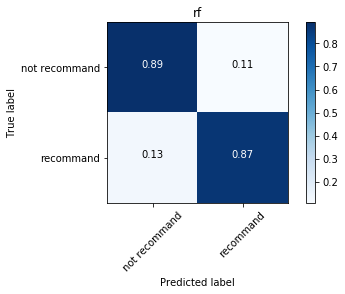

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [17]:
from sklearn.metrics import *
from sklearn.preprocessing import *
from sklearn.ensemble import *
def rf():
    # find X,and y
    # factorize(),MinMaxScaler() 函數以上做過解釋，不多重複介紹。
    raw_data['uid'] = pd.factorize(raw_data['UserId'])[0]
    raw_data['pid'] = pd.factorize(raw_data['ProductId'])[0]
    from sklearn.preprocessing import MinMaxScaler
    sc = MinMaxScaler()
    raw_data['time']=sc.fit_transform(raw_data['Time'].values.reshape(-1,1))
    raw_data['nuser']=sc.fit_transform(raw_data['#Users'].values.reshape(-1,1))
    raw_data['nproduct']=sc.fit_transform(raw_data['#Proudcts'].values.reshape(-1,1))
    
    # .loc[] . 將以上處理後的資料存入不同的變數中，以利進行接下來的訓練。
    X1 = raw_data.loc[:,['uid','pid']]
    X2 = raw_data.loc[:,['uid','pid','time']]
    X3 = raw_data.loc[:,['uid','pid','time','nuser','nproduct']]
    y = raw_data.Score

    # train_test_split() . 分割X為訓練集與測試集，分別將大小定為 0.7與 0.3。
    from sklearn.model_selection import train_test_split
    X1_train,X1_test,y_train,y_test = train_test_split(X1,y,test_size=0.3,random_state=2017)
    X2_train,X2_test,y_train,y_test = train_test_split(X2,y,test_size=0.3,random_state=2017)
    X3_train,X3_test,y_train,y_test = train_test_split(X3,y,test_size=0.3,random_state=2017)
    
    # 以 rfr 模型訓練資料
    a=RandomForestRegressor()
    a.fit(X3_train,y_train)
    y3 = a.predict(X3_test)
    sc = MinMaxScaler(feature_range=(1,5))
    
    # 分別求出訓練集與測試集的方均差，以判斷訓練效果。
    c = mean_squared_error(y_train,a.predict(X3_train)), mean_squared_error(y_test,sc.fit_transform(y3.reshape(-1,1)))
    b = mean_squared_error(y_test,y3)
    print('train MSE is {}, test MSE is {}'.format(c,b))

    # 將推薦與不推薦的準確率分別計算出來
    c3 = y3>=4
    t = y_test>=4
    print('accrucy of recommandtion:')
    print(accuracy_score(t,c3))
    c31 = y3<=1
    t1 = y_test<=1
    print('accrucy of not recommandtion:')
    print(accuracy_score(t1,c31))
    
    # 創造兩個矩陣用於繪製混淆矩陣，兩矩陣分別用於儲存預測值與測試值
    y_pred3 = []
    y_test3 = []
    for i in range(y3.shape[0]):
        if y3[i]>=4:
            y_pred3.append(1)
        elif y3[i]<4:
            y_pred3.append(0)
        # else:
            # y_pred3.append(1)

    for j in range(y3.shape[0]):
        if np.array(y_test)[j]>=4:
            y_test3.append(1)
        elif np.array(y_test)[j]<4:
            y_test3.append(0)
        # else:
            # y_test3.append(1)
            
    # 將混淆矩陣基本程式碼複製過來後，將繪製來源改為以上創造的兩個矩陣，便可以繪製以此模型訓練後的混淆矩陣。
    import itertools
    import matplotlib.pyplot as plt
    def plot_confusion_matrix(cm, classes,
                              normalize=False,
                              title='Confusion matrix',
                              cmap=plt.cm.Blues):
        """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
        """
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            print("Normalized confusion matrix")
        else:
            print('Confusion matrix, without normalization')

        print(cm)
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
    class_names = ['not recommand','recommand']
    cnf_matrix = confusion_matrix(y_test3,y_pred3)
    np.set_printoptions(precision=2)
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                          title='rf')


    plt.show()
    return a
rf()

#### 結果觀察
    
我們可以看到 MSE（方均差）並不是非常高，而從混淆矩陣顯示的結果看來，也是可以接受的。因此，由 Random Forest Regressor 模型訓練資料的結果是不錯的，我們接著繼續嘗試不同的模型。不過，由於是以推薦系統為主題，而以上方法顯示的推薦資訊並不夠完整，所以我又定義了一個方法來顯示完整的推薦資訊。

### 定義推薦資訊顯示方法

In [24]:
def rec(result, uid,n,rawId= False):
    if uid in range(total_u):
        #np.argpartition() 函數是一個我認為較 np.argsort() 高效地排列方式，兩個都可以使用，看自己習慣。
		# we take the first n people's highest score product
        top_N = np.argpartition(result[uid],-n)[-n:]
        print('為用戶 {} 推薦的前{}名產品為 {}'.format(uid,n,top_N))
		# if rawID is on, the out put contains the real product id
        if rawId == True:
            print('real ID 是 {}'.format(pid2PID[top_N]))
    else:
        print('該用戶尚未購買產品，請使用其他方法')
    return top_N

### 以距離為基準的模型

定義完推薦資訊顯示方法後，繼續嘗試不同的模型，首先嘗試的是 Distance Based Model ，此模型會給出向量間的相似程度。我們以 cosine 的方式來計算兩個內部產品空間中的非0向量間角度的相似程度，會在範圍 -1 到 1 之間（-1表示完全相反，1表示完全相同）。

由於傳統協同過濾模型的方均差會稍高，我決定使用 quasi-SVD 替代。由此方法，輸出的矩陣會是三個矩陣的點產物。

the in sample MSE = 2.181532608112232 
the out sample MSE = 2.258277969585437
caculating cm..
Normalized confusion matrix
[[0.42 0.58]
 [0.34 0.66]]


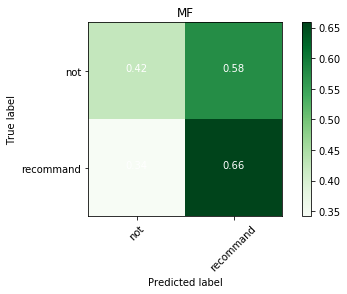

為用戶 10 推薦的前 10 名產品為 [ 644  151  455   52 1072 1051  127 1067  106    0]
real ID 是 ['B0058AMYTC' 'B00472I5A4' 'B0058AMY10' 'B0058AMY74' 'B001SAXPEO'
 'B006WYSFZK' 'B000G6MBUA' 'B004728MI4' 'B0012XBD7I' 'B000G6RYNE']


array([ 644,  151,  455,   52, 1072, 1051,  127, 1067,  106,    0])

In [21]:
from sklearn.metrics.pairwise import pairwise_distances
def cf(table = table,distance = 'cosine'):
    user_similarity = pairwise_distances(table, metric=distance)
    item_similarity = pairwise_distances(table.T, metric=distance)
    sc = MinMaxScaler(feature_range=(1,5))
    a = sc.fit_transform(np.dot(user_similarity,table).dot(item_similarity))
    return a
result =cf()
caculate_mse(result)
drawcm(result,title='MF')
rec(result, 10,10,rawId= True)

    由此結果，發現此方法的優勢是他是較可讀可解釋的。
    不過他的缺點也很明顯，對於較龐大的資料集，需要較長的計算時間。
    m^2+n^2 ，需要數學佐證，不多作解釋。

### SVD

在我們的推薦系統中，我們有矩陣顯示出很多用戶對於產品的評分。在前面有提到，我希望利用這些資料做出分數預測，並對目標用戶提供推薦資訊。
而接下來我要使用到的SVD 模型的優勢在於用戶評分矩陣是一個稀疏矩陣（定義及用法會用文檔解釋），這會使我們可以將原始資料降維，讓計算複雜度降低，也就解決了上一個模型發生的問題：

the in sample MSE = 0.3982335596954266 
the out sample MSE = 0.39813597209585755
caculating cm..
Normalized confusion matrix
[[0.96 0.04]
 [0.15 0.85]]


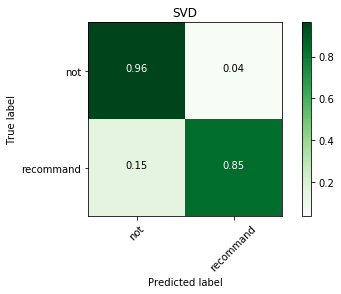

為用戶 10 推薦的前10名產品為 [ 918 1072 1067  151  127  799  106   52 1051    0]
real ID 是 ['B000G6O2QG' 'B001SAXPEO' 'B004728MI4' 'B00472I5A4' 'B000G6MBUA'
 'B0058AMY5G' 'B0012XBD7I' 'B0058AMY74' 'B006WYSFZK' 'B000G6RYNE']


array([ 918, 1072, 1067,  151,  127,  799,  106,   52, 1051,    0])

In [23]:
from numpy import *
from scipy.sparse.linalg import svds
from numpy import linalg as la
from sklearn.preprocessing import MinMaxScaler
def svdrec(table = table, factors= 150):
    UI = matrix(table)
    # ui_df = pd.DataFrame(UI,index=table.index, columns=table.columns)
    # 使用mean() 函數計算評分的平均
    user_ratings_mean=mean(UI,axis=0)
    # 計算平均後，資料的結構會亂掉，我們用 np.reshape() 函數將矩陣重組
    # 參數 -1 在函數中表示自動計算矩陣裡面所有元素的個數
    user_ratings_mean=user_ratings_mean.reshape(1,-1)
    
    # 參照 SVD 模型 原理及用法：
    UI_demeaned=UI-user_ratings_mean
    U,sigma,Vt=svds(UI_demeaned,factors)
    sigma=diag(sigma)
    pred_mat=dot(dot(U,sigma),Vt) + user_ratings_mean
    sc=MinMaxScaler(feature_range = (1,5))
    pred_mat = sc.fit_transform(pred_mat)
    # prediction_df=pd.DataFrame(pred_mat,index=table.index,columns=table.columns)
    return pred_mat
def rec(result, uid,n,rawId= False):
    if uid in range(total_u):
		# we take the first n people's highest score product
        top_N = np.argpartition(result[uid],-n)[-n:]
        print('為用戶 {} 推薦的前{}名產品為 {}'.format(uid,n,top_N))
		# if rawID is on, the out put contains the real product id
        if rawId == True:
            print('real ID 是 {}'.format(pid2PID[top_N]))
    else:
        print('該用戶尚未購買產品，請使用其他方法')
    return top_N
result1 =svdrec(factors=150)
caculate_mse(result1)
drawcm(result1,title='SVD')
rec(result1, 10,10,rawId= True)

    由此結果我們可以觀察到，相對於以上一個模型訓練資料，這次的結果好了非常多，不僅推薦的準確度較高，計算複雜度也較低。

### Matrix Factoriztion

Latent factor models are an alternative approach that tries to explain the ratings by characterizing both items and users on, say, 20 to 100 factors inferred from the ratings patterns. For products, the discovered factors might measure obvious dimensions such as candy vs drinks, or adult food vs children’s; For users, each factor measures how much the user likes the product that score high on the corresponding movie factor. Using latent factor model, we transform the way to calculate the similarity of users and products. The features become more stable and condense.

    首先，我們先建立兩個新的矩陣，分別為 user_latent_factor 和 product_latent_factor 。大小為 qf 和 pf ，q p 分別為用戶以及產品的總數，而 f 為潛在因素的數量，如此，便可以開始計算目標矩陣。
    
    接著，定義一個基於最小方均差函數的目標導向方法，這個方法能幫助我們訓練到損失最小的狀況。
    

In [10]:
def MF1(data=z, factors=30, maxIter=100, LRate=0.02, GD_end=1e-3, plot=False):
    # initial the latent matrix for user and item
    P = np.random.rand(total_u, factors) / 3
    Q = np.random.rand(total_p, factors) / 3
    # initial y as the history of loss
    y = []
    # initial the iteration and last loss
    iteration = 0
    last_loss = 0
    while iteration < maxIter:
        loss = 0
        for i in range(data.shape[0]):
            # get the uid,pid and the score from every line
            u, p, s = data[i]
            # calculate the error
            error = s - np.dot(P[u], Q[p])
            # calculate the loss function
            # avoid loss become to large, scale to 1/50
            loss += error ** 2 / 50
            # update the parameter according to the gradient descent
            pp = P[u]
            qq = Q[p]
            P[u] += LRate * error * qq
            Q[p] += LRate * error * pp
        iteration += 1
        y.append(loss)
        delta_loss = last_loss - loss
        print('iter = {}, loss = {}, delta_loss = {}, LR = {}'.format(iteration, loss, delta_loss, LRate))
        # update the learn rate to make sure it will converge
        if abs(last_loss) > abs(loss):
            LRate *= 1.05
        else:
            LRate *= 0.5
        # When converge, stop the gradient descend
        if abs(delta_loss) < abs(GD_end):
            print('the diff in loss is {}, so the GD stops'.format(delta_loss))
            break
        last_loss = loss
    if plot:
        plt.plot(y)
        plt.show()
    return P.dot(Q.T)

### 訓練開始囉！

The system adjusts the model by fitting the previously observed ratings. However, the goal is to generalize those previous ratings in a way that predicts the unknown ratings. Thus, the system should avoid overfitting the observed data by regularizing the learned parameters by adding L2 term. The constant λ controls the extent of regularization and is usually determined by cross-validation. Next, we use stochastic gradient descent to optimize the objective function. 

Where gamma is the stochastic learning rate and e is the error term. In the iteration, when the change in loss is larger than 0, the learning rate increases by 5%; if delta-loss is smaller than 0, it means the new loss is becoming larger. The learning rate decreases by 50% so that the loss can converge.

iter = 1, loss = 3290.948884946758, delta_loss = -3290.948884946758, LR = 0.02
iter = 2, loss = 959.398582108444, delta_loss = 2331.550302838314, LR = 0.01
iter = 3, loss = 621.0435581171475, delta_loss = 338.35502399129643, LR = 0.0105
iter = 4, loss = 572.1756559275968, delta_loss = 48.867902189550705, LR = 0.011025000000000002
iter = 5, loss = 536.9544607895344, delta_loss = 35.2211951380624, LR = 0.011576250000000003
iter = 6, loss = 501.0207073284666, delta_loss = 35.93375346106785, LR = 0.012155062500000004
iter = 7, loss = 460.9884894843683, delta_loss = 40.032217844098284, LR = 0.012762815625000005
iter = 8, loss = 417.71407616828355, delta_loss = 43.27441331608475, LR = 0.013400956406250006
iter = 9, loss = 373.41339854373945, delta_loss = 44.30067762454411, LR = 0.014071004226562506
iter = 10, loss = 329.9940045899803, delta_loss = 43.41939395375914, LR = 0.014774554437890632
iter = 11, loss = 289.0851249328683, delta_loss = 40.90887965711198, LR = 0.015513282159785164
iter =

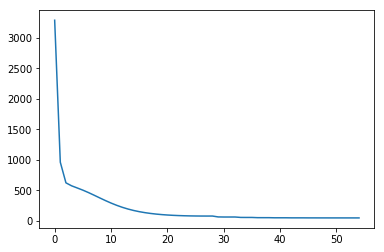

the in sample MSE = 0.035369441873866064 
the out sample MSE = 0.033801742358736835
caculating cm..
Normalized confusion matrix
[[0.99 0.01]
 [0.14 0.86]]


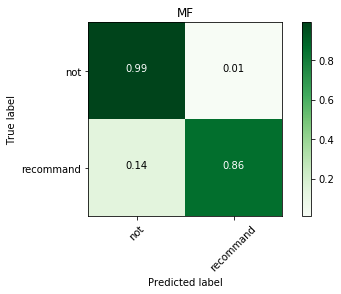

為用戶 10 推薦的前10名產品為 [ 729 1093  256  201  595  182  155   80  243   96]
real ID 是 ['B000ZSZ5S4' 'B004HOSGWE' 'B004HOQE64' 'B001EQ4QJK' 'B004HOOZEW'
 'B004HOLD4W' 'B001EQ4RBM' 'B001EQ4P2I' 'B001KVPBS4' 'B004HOLD92']


array([ 729, 1093,  256,  201,  595,  182,  155,   80,  243,   96])

In [25]:
result =MF1( factors=30, maxIter=100, LRate=0.02, GD_end=1e-3, plot=1)
caculate_mse(result)
drawcm(result,title='MF')
def rec(result, uid,n,rawId= False):
    if uid in range(total_u):
		# we take the first n people's highest score product
        top_N = np.argpartition(result[uid],-n)[-n:]
        print('為用戶 {} 推薦的前{}名產品為 {}'.format(uid,n,top_N))
		# if rawID is on, the out put contains the real product id
        if rawId == True:
            print('real ID 是 {}'.format(pid2PID[top_N]))
    else:
        print('該用戶尚未購買產品，請使用其他方法')
    return top_N
rec(result, 10,10,rawId= True)

    觀察以上結果，由損失隨迭代次數提升的下降率，我們可以發現圖形呈現「肘型」的樣子，這表示資料會隨著迭代次數越來越沒有效率，也就是說，如果需要訓練的資料非常龐大，我們可以控制該模型跑到「肘點」就好了，這樣效率會大幅度提升，結果也不會差太多，更能減少成本。
    
    接著，觀察混淆矩陣，可以發現經過不斷迭代訓練的資料相對於之前準確性有很大的提升，這也會直接導致預測的結果會更好。以產品推薦資訊為例，我們藉由此就可以準確的預測用戶會購買的潛在商品，並作出更好的推薦資訊、廣告投放等等。

### Probabilistic Matrix Factoriztion

儘管剛剛的結果已經達成我所預定的目標，不過這邊我還是想試試看一個與 MF 相當相似的推薦系統演算法（Probabilistic Matrix Factoriztion - PMF），以此觀察兩種演算法成效差異。

    理論上來說，PMF會比MF多出：
    1. 用戶與產品的高斯分佈假設
    2. 對稀疏矩陣的梯度下降過程處理得更好。
        第二點也是由於多出的高斯分佈假設，這能使預測更為準確。

iter = 1, loss = 3463.039073299022, delta_loss = -3363.039073299022, LR = 0.02
iter = 2, loss = 1107.3304664176942, delta_loss = 2355.708606881328, LR = 0.01
iter = 3, loss = 789.2532619363215, delta_loss = 318.07720448137275, LR = 0.0105
iter = 4, loss = 745.1255103686335, delta_loss = 44.12775156768794, LR = 0.011025000000000002
iter = 5, loss = 715.0196860492166, delta_loss = 30.10582431941691, LR = 0.011576250000000003
iter = 6, loss = 684.9630709461223, delta_loss = 30.05661510309426, LR = 0.012155062500000004
iter = 7, loss = 650.871306068651, delta_loss = 34.09176487747129, LR = 0.012762815625000005
iter = 8, loss = 612.7451074438544, delta_loss = 38.12619862479664, LR = 0.013400956406250006
iter = 9, loss = 572.8091678620531, delta_loss = 39.935939581801335, LR = 0.014071004226562506
iter = 10, loss = 533.3182804067711, delta_loss = 39.49088745528195, LR = 0.014774554437890632
iter = 11, loss = 495.7982767422677, delta_loss = 37.520003664503406, LR = 0.015513282159785164
iter =

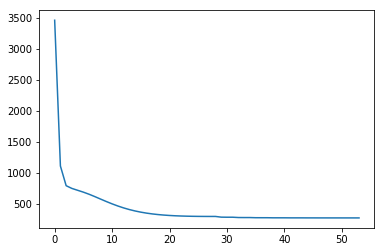

the in sample MSE = 0.03780202135302932 
the out sample MSE = 0.03619934343418913
caculating cm..
Normalized confusion matrix
[[0.99 0.01]
 [0.19 0.81]]


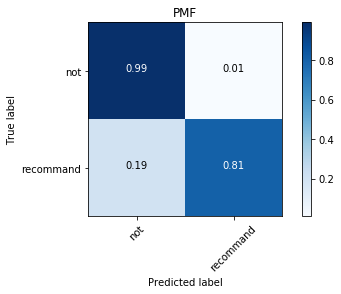

the top10 recommanded products for user 10 is [467 624 629 739 894 833 374 504 512 969]
the real ID is ['B008YA1NWC' 'B007TJGY5K' 'B003Z6W32E' 'B004NSH6O8' 'B001D0GVAO'
 'B005NVU5BK' 'B001EO5Q64' 'B003G52BN0' 'B000H7LVKY' 'B000HDK0DC']


array([467, 624, 629, 739, 894, 833, 374, 504, 512, 969])

In [12]:
def PMF(data=z, factors=30, maxIter=100, LRate=0.02, GD_end=1e-3, regU = 0.01 ,regI = 0.01 ,plot=False):
    P = np.random.rand(total_u, factors) / 3
    Q = np.random.rand(total_p, factors) / 3
    y = []
    iteration = 0
    last_loss = 100
    while iteration < maxIter:
        loss = 0
        for i in range(data.shape[0]):
            u, p, s = data[i]
            error = s - np.dot(P[u], Q[p])
            loss += error ** 2/50
            pp = P[u]
            qq = Q[p]
            P[u] += LRate *  (error * qq - regU*pp)
            Q[p] += LRate * (error * pp - regI * qq)
        loss += regU*(P*P).sum() +regI*(Q*Q).sum()
        iteration += 1
        y.append(loss)
        delta_loss = last_loss - loss
        print('iter = {}, loss = {}, delta_loss = {}, LR = {}'.format(iteration, loss, delta_loss, LRate))
        if abs(last_loss) > abs(loss):
            LRate *= 1.05
        else:
            LRate *= 0.5

        if abs(delta_loss) < abs(GD_end):
            print('the diff in loss is {}, so the GD stops'.format(delta_loss))
            break
        last_loss = loss
    if plot:
        plt.plot(y)
        plt.show()
    return P.dot(Q.T)
result =PMF( factors=30, maxIter=100, LRate=0.02, GD_end=1e-3, plot=1)
caculate_mse(result)
drawcm(result,title='PMF')
def rec(result, uid,n,rawId= False):
    if uid in range(total_u):
		# we take the first n people's highest score product
        top_N = np.argpartition(result[uid],-n)[-n:]
        print('the top{} recommanded products for user {} is {}'.format(n,uid,top_N))
		# if rawID is on, the out put contains the real product id
        if rawId == True:
            print('the real ID is {}'.format(pid2PID[top_N]))
    else:
        print('this user has not bought anything, plz use other methods')
    return top_N
rec(result, 10,10,rawId= True)


    觀察此結果，並與 MF 的結果對比，我們發現其實相差不大，甚至可以說近乎是一樣的效果。還記得我們剛才說 PMF 比 MF 多出了高斯分布假定能夠讓其預測更到味，但貌似並沒有發生，為什麼呢？
    
    其實原因很簡單，因為我所使用的矩陣並非稀疏矩陣，這也導致前提並沒有達成，所以結果才會如此相似。
    
## 結論

不管是 MF 還是 PMF 其實都達成了我對於此推薦系統的目標 -- 提供個別用戶詳細的推薦資訊。

這次的以製作推薦系統為主題的期末專題，歷時了將近一個月，為了將達成預定的目標，花費了相當多的心力，例如：學習機器學習中的各種訓練方法、回顧各種模型的原理及功能、學習推薦系統的進階演算法等等。不過也因此得到了相當多的東西，這是在其他課程都無法達到的程度，非常感謝老師設計這樣的期末專題讓我們實作，讓我們在壓力中逼迫自己成長進步。

# 感謝老師與助教的觀看，謝謝！